# Projecting conflict risk

In this notebook, we will show how CoPro can use a previously fitted classifier to make projections of conflict risk.

## Preparations

Start with loading the required packages.

In [1]:
from copro import utils, pipeline, evaluation, plots, machine_learning

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
from shutil import copyfile
import warnings
import glob
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.8b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


To be able to also run this notebooks, some of the previously saved data needs to be loaded.

In [3]:
conflict_gdf = gpd.read_file(os.path.join('temp_files', 'conflicts.shp'))
selected_polygons_gdf = gpd.read_file(os.path.join('temp_files', 'polygons.shp'))

In [4]:
global_arr = np.load(os.path.join('temp_files', 'global_df.npy'), allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

### The configurations-file (cfg-file)

In the cfg-file, all the settings for the analysis are defined. Note that the cfg-file can be stored anywhere, not per se in the same directory where the model data is stored (as in this example case). Make sure that the paths in the cfg-file are updated if you use relative paths and change the folder location of th cfg-file.

Note that only a few settings of the cfg-file are needed for making projections. Most relevant is the path to the pickled classifier and the data to be used for the samples matrix (X). For convenience, though, the same file structure can be used and CoPro picks the settings needed.

In [5]:
settings_file = 'example_settings.cfg'

Based on this cfg-file, the set-up of the run can be initialized. Here, the cfg-file is parsed (i.e. read) and all settings and paths become known to the model. Also, the output folder is created (if it does not exist yet) and the cfg-file is copied to the output folder for improved reusability.

In [6]:
main_dict, root_dir = utils.initiate_setup(settings_file)


#### CoPro version 0.0.8b ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2021): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: parsing configurations for file example_settings.cfg
INFO: parsing configurations for file C:\Users\hoch0001\Documents\_code\copro\example\example_settings_proj.cfg
INFO: parsing configurations for file C:\Users\hoch0001\Documents\_code\copro\example\example_settings_proj.cfg
INFO: verbose mode on: True
INFO: saving output to main folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT
DEBUG: remove files in C:\Users\hoch0001\Documents\_code\copro\example\OUT\_REF
DEBUG: sparing XY.npy
DEBUG: remove files in C:\Users\hoch0001\Documents\_code\copro\example\OUT\_REF\clfs
DEBUG: remove files in C:\Users\hoch0001\Documents\_code\copro\example\OUT\_REF\files
DEBUG: remove files in C:\

In [7]:
main_dict

{'_REF': [<configparser.RawConfigParser at 0x2070b865a88>,
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_REF'],
 'test1': [[<configparser.RawConfigParser at 0x2070b866148>],
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_PROJ\\test1'],
 'testZWEI': [[<configparser.RawConfigParser at 0x2070b831f48>],
  'C:\\Users\\hoch0001\\Documents\\_code\\copro\\example\\./OUT\\_PROJ\\testZWEI']}

In [8]:
config_REF = main_dict['_REF'][0]
out_dir_REF = main_dict['_REF'][1] 

In a previous notebook, conflict at the last year of the simulation period was stored temporarily to another folder than the output folder. Now let's copy these files back to the folder where the belong.

In [9]:
%%capture

for root, dirs, files in os.walk('temp_files'):
    
    # conflicts at last time step
    files = glob.glob(os.path.abspath('./temp_files/conflicts_in*'))
    for file in files:
        fname = file.rsplit('\\')[-1]
        print(fname)
        copyfile(os.path.join('temp_files', fname),
                 os.path.join(out_dir_REF, 'files', str(fname)))
        
    # classifiers
    files = glob.glob(os.path.abspath('./temp_files/clf*'))
    for file in files:
        fname = file.rsplit('\\')[-1]
        print(fname)
        copyfile(os.path.join('temp_files', fname),
                 os.path.join(out_dir_REF, 'clfs', str(fname)))

## Fill gap period between reference run and projection period

Read the conflict occurence per polygon at the last time step of the reference run.

In [10]:
print('reading previous conflicts from file {}'.format(os.path.join(out_dir_REF, 'files', 'conflicts_in_{}.csv'.format(config_REF.getint('settings', 'y_end')))))
conflict_gdf_test = pd.read_csv(os.path.join(out_dir_REF, 'files', 'conflicts_in_{}.csv'.format(config_REF.getint('settings', 'y_end'))), index_col=0)

reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\files\conflicts_in_2012.csv


## Project!

Before we can make a projection, we need to first get the scaler for the samples matrix again. The pre-computed classifier (based on the reference run) is directly loaded from file as specified in the cfg-file.

In [11]:
scaler, clf = pipeline.prepare_ML(config_REF)

DEBUG: chosen scaling method is QuantileTransformer(random_state=42)
DEBUG: chosen ML model is RandomForestClassifier(class_weight={1: 100}, n_estimators=1000,
                       random_state=42)


With this all in place, we can use the X-array, the scaler, and the fitted classifier to make a projection whether conflict will take place in a polygon or not.

In [12]:
all_y_df = pipeline.run_prediction(scaler, main_dict, root_dir, selected_polygons_gdf, conflict_gdf)

INFO: loading config-object for projection run: test1
DEBUG: storing output for this projections to folder C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1
INFO: determinining annual conflict occurence from end of reference run until end of projection run
DEBUG: the projection period is 2013 to 2025
INFO: making projection for year 2013
DEBUG: the columns in the sample matrix used are:
...poly_ID
...poly_geometry
...gdp
...conflict_t_min_1
...conflict_t_min_1_nb
INFO: reading sample data from files
INFO: entering year 2013
DEBUG: getting the geometry of all geographical units
DEBUG: calculating log-transformed mean gdp per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\./example_data\gdp/gdp_Africa.nc for year 2013
DEBUG: ... done.
INFO: all data read
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\files\conflicts_in_2012.csv
DEBUG: combining sample data with conflict data from previous y

INFO: entering year 2014
INFO: all data read
DEBUG: number of data points including missing values: 262
DEBUG: number of data points excluding missing values: 262
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_6.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_6.pkl\projection_for_2013.csv
DEBUG: combining sample data with conflict data for clf_6.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2014
INFO: all data read
DEBUG: number of data points including missing values: 262
DEBUG: number of data points excluding missing values: 262
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_7.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\

DEBUG: loading classifier clf_8.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_8.pkl\projection_for_2014.csv
DEBUG: combining sample data with conflict data for clf_8.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2015
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_9.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_9.pkl\projection_for_2014.csv
DEBUG: combining sample data with conflict data for clf_9.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2015
INF

DEBUG: ... done.
INFO: all data read
DEBUG: loading classifier clf_1.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_1.pkl\projection_for_2016.csv
DEBUG: combining sample data with conflict data for clf_1.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2017
INFO: all data read
DEBUG: number of data points including missing values: 274
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_10.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_10.pkl\projection_for_2016.csv
DEBUG: combining sample data with conflict data for clf_10.pkl
DEBUG: determining matrix with neighbori

DEBUG: combining sample data with conflict data for clf_2.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2018
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_3.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_3.pkl\projection_for_2017.csv
DEBUG: combining sample data with conflict data for clf_3.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2018
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_4.pkl from C:

DEBUG: loading classifier clf_5.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_5.pkl\projection_for_2018.csv
DEBUG: combining sample data with conflict data for clf_5.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2019
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_6.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_6.pkl\projection_for_2018.csv
DEBUG: combining sample data with conflict data for clf_6.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2019
INF

INFO: entering year 2020
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_8.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_8.pkl\projection_for_2019.csv
DEBUG: combining sample data with conflict data for clf_8.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2020
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_9.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\

DEBUG: storing model output for year 2021 to output folder
INFO: making projection for year 2022
DEBUG: the columns in the sample matrix used are:
...poly_ID
...poly_geometry
...gdp
...conflict_t_min_1
...conflict_t_min_1_nb
INFO: reading sample data from files
INFO: entering year 2022
DEBUG: getting the geometry of all geographical units
DEBUG: calculating log-transformed mean gdp per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\./example_data\gdp/gdp_Africa.nc for year 2022
DEBUG: ... done.
INFO: all data read
DEBUG: loading classifier clf_1.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_1.pkl\projection_for_2021.csv
DEBUG: combining sample data with conflict data for clf_1.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2022
INFO: all data read
DEBUG: number of data points including m

INFO: entering year 2023
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_2.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\test1\clfs\clf_2.pkl\projection_for_2022.csv
DEBUG: combining sample data with conflict data for clf_2.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2023
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_3.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\

DEBUG: loading classifier clf_7.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
DEBUG: number of data points including missing values: 262
DEBUG: number of data points excluding missing values: 262
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_8.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
DEBUG: number of data points including missing values: 262
DEBUG: number of data points excluding missing values: 262
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_9.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
DEBUG: number of data points including missing values: 262
DEBUG: number of data points excluding missing values: 262
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: storing model output for year 2013 to output folder
INFO: making projection for year 2014
DEBUG: th

DEBUG: ... done.
INFO: all data read
DEBUG: loading classifier clf_1.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_1.pkl\projection_for_2014.csv
DEBUG: combining sample data with conflict data for clf_1.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2015
INFO: all data read
DEBUG: number of data points including missing values: 274
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_10.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_10.pkl\projection_for_2014.csv
DEBUG: combining sample data with conflict data for clf_10.pkl
DEBUG: determining matrix with nei

INFO: entering year 2016
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_3.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_3.pkl\projection_for_2015.csv
DEBUG: combining sample data with conflict data for clf_3.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2016
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_4.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Use

DEBUG: loading classifier clf_5.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_5.pkl\projection_for_2016.csv
DEBUG: combining sample data with conflict data for clf_5.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2017
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_6.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_6.pkl\projection_for_2016.csv
DEBUG: combining sample data with conflict data for clf_6.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 20

INFO: entering year 2018
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_8.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_8.pkl\projection_for_2017.csv
DEBUG: combining sample data with conflict data for clf_8.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2018
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_9.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Use

DEBUG: storing model output for year 2019 to output folder
INFO: making projection for year 2020
DEBUG: the columns in the sample matrix used are:
...poly_ID
...poly_geometry
...gdp
...conflict_t_min_1
...conflict_t_min_1_nb
INFO: reading sample data from files
INFO: entering year 2020
DEBUG: getting the geometry of all geographical units
DEBUG: calculating log-transformed mean gdp per aggregation unit from file C:\Users\hoch0001\Documents\_code\copro\example\./example_data\gdp/gdp_Africa.nc for year 2020
DEBUG: ... done.
INFO: all data read
DEBUG: loading classifier clf_1.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_1.pkl\projection_for_2019.csv
DEBUG: combining sample data with conflict data for clf_1.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2020
INFO: all data read
DEBUG: number of data points includin

INFO: entering year 2021
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_2.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_2.pkl\projection_for_2020.csv
DEBUG: combining sample data with conflict data for clf_2.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2021
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_3.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Use

DEBUG: loading classifier clf_4.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_4.pkl\projection_for_2021.csv
DEBUG: combining sample data with conflict data for clf_4.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2022
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_5.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_5.pkl\projection_for_2021.csv
DEBUG: combining sample data with conflict data for clf_5.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 20

DEBUG: combining sample data with conflict data for clf_6.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2023
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_7.pkl from C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_REF\clfs
INFO: reading previous conflicts from file C:\Users\hoch0001\Documents\_code\copro\example\./OUT\_PROJ\testZWEI\clfs\clf_7.pkl\projection_for_2022.csv
DEBUG: combining sample data with conflict data for clf_7.pkl
DEBUG: determining matrix with neighboring polygons
INFO: entering year 2023
INFO: all data read
DEBUG: number of data points including missing values: 267
DEBUG: number of data points excluding missing values: 267
INFO: scaling the data from projection period
INFO: making the projections
DEBUG: loading classifier clf_8.pkl from

## Analysis of projection

All the previously used evaluation metrics are not applicable anymore, as there are no target values anymore. We can still look which chance of conflict is computed by the model.

Above, we got a 'master dataframe' containing all output for all projections made, which in turn consist of the projections made per classifier. The total number of projections is thus number of data points times number of model runs (i.e. classifiers) times number of projections made.

These results can be analysed separately. For now, we want to limit ourselves to the first projection.

In [13]:
y_df = all_y_df.iloc[:int(len(all_y_df)/len(main_dict['_REF'][0].items('PROJ_files'))), :]

Based on each classifier, we can check what map of projected conflict risk they produce. To that end, we split the above created dataframe (y_df) into chunks whose number corresponds with the number of classifiers.

In [14]:
clfs = machine_learning.load_clfs(config_REF, out_dir_REF)

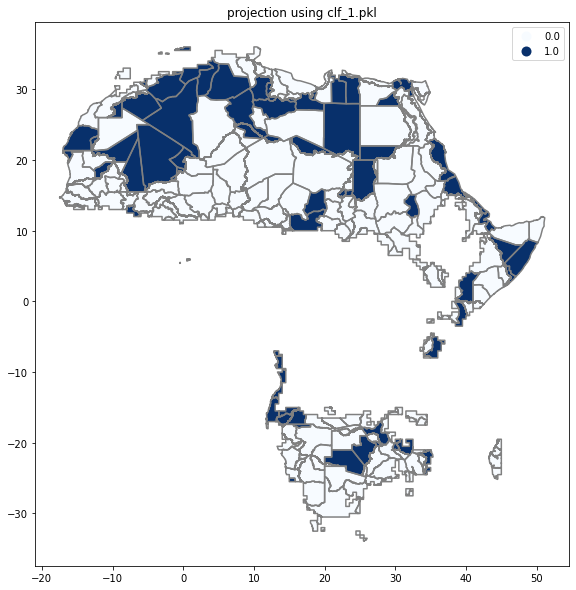

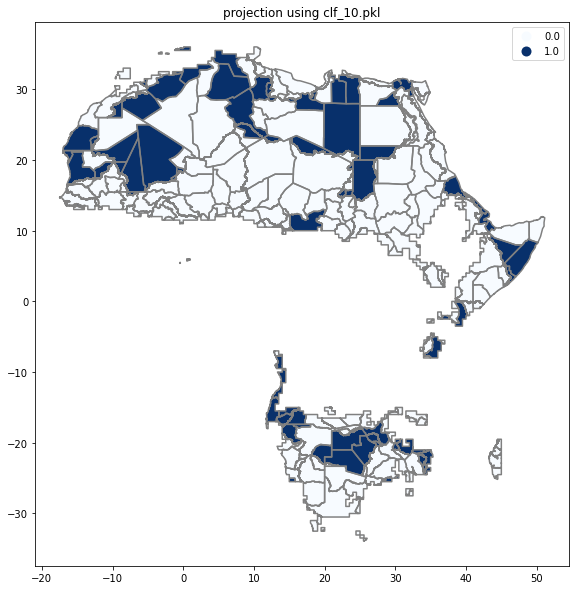

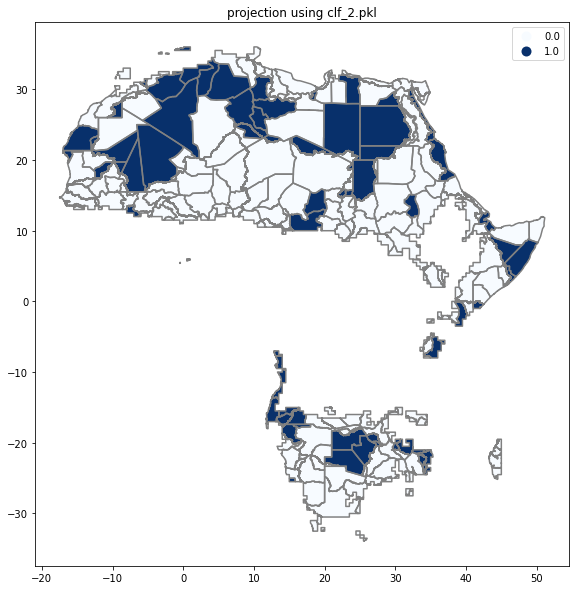

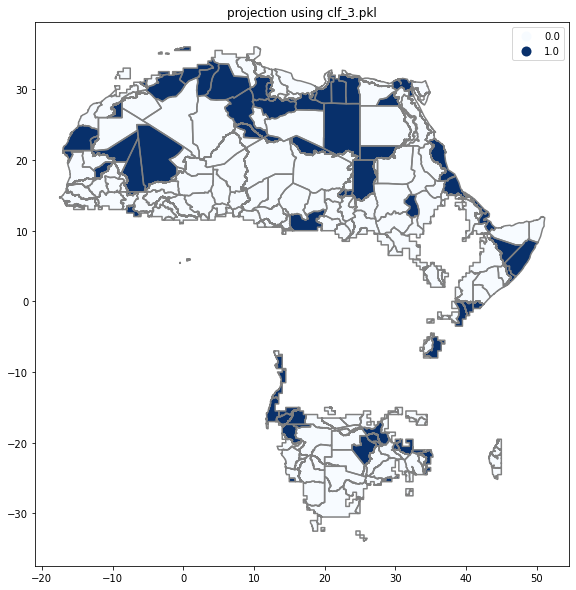

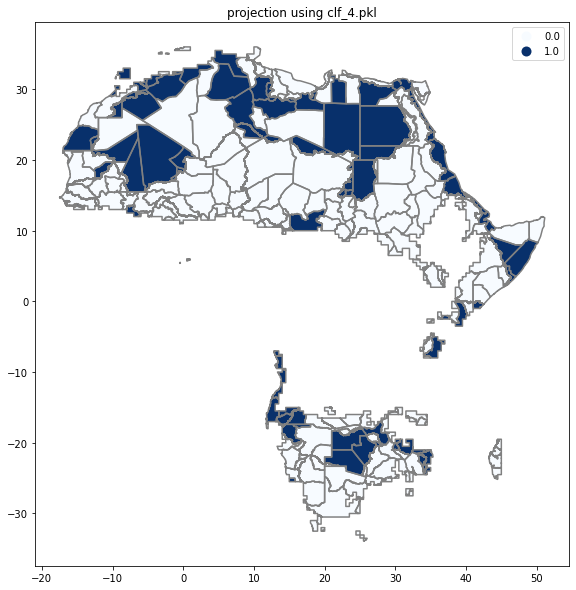

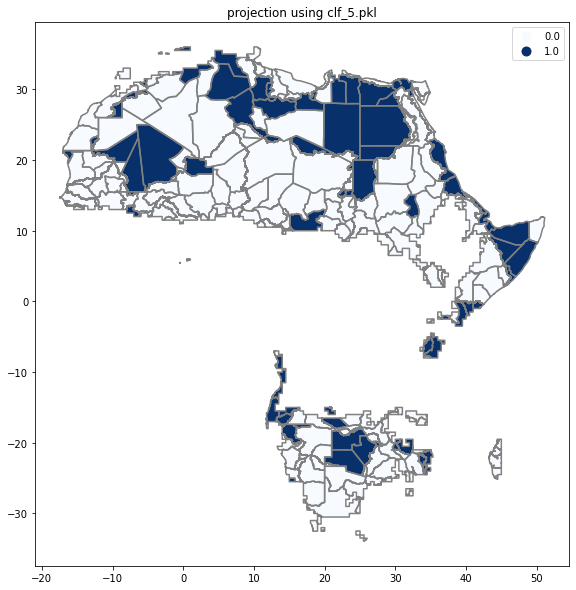

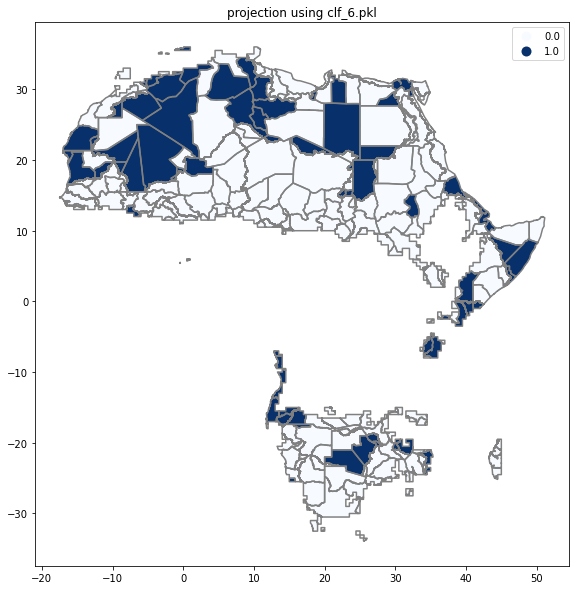

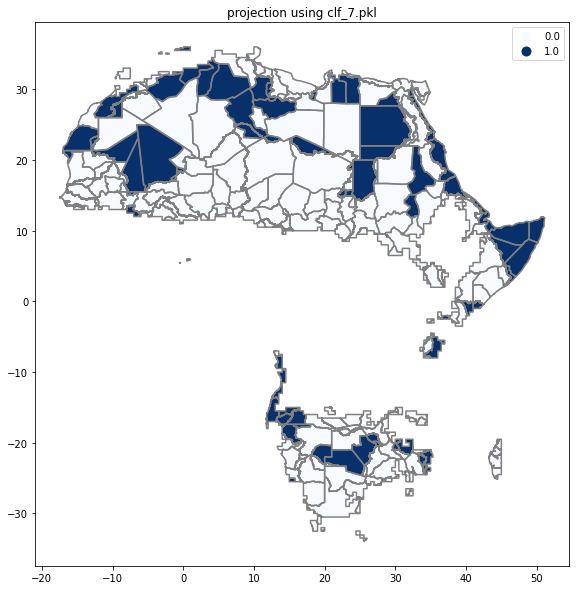

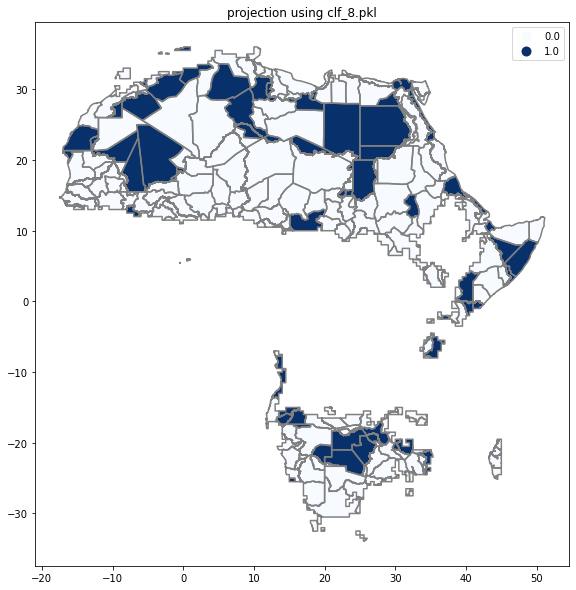

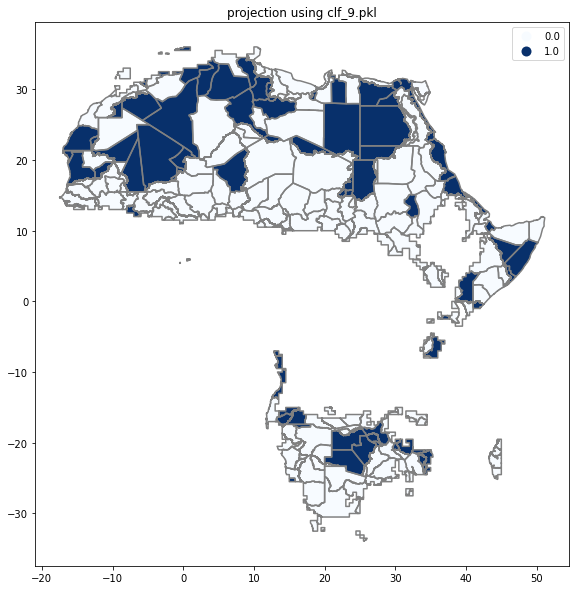

In [15]:
# initiate a count to keep track with the begin and end indixes per slice
count = 0

# loop through all runs/classifiers created
for i, clf in zip(range(config_REF.getint('machine_learning', 'n_runs')), clfs):
    
    # for the first chunk, the slicing needs to be done differenctly
    if i == 0:
        # get the first chunk of the dataframe
        y_df_i = y_df.iloc[:int(len(y_df)/config_REF.getint('machine_learning', 'n_runs')), :]
        # update the count
        count += int(len(y_df)/config_REF.getint('machine_learning', 'n_runs'))
    else:
        # get the remaining chunks piece by piece
        y_df_i = y_df.iloc[count+1:count+1+int(len(y_df)/config_REF.getint('machine_learning', 'n_runs')), :]
        # update the count
        count += int(len(y_df)/config_REF.getint('machine_learning', 'n_runs'))
    
    # get the output analysis metrics per chunk that is per classifier
    df_hit, gdf_hit = evaluation.polygon_model_accuracy(y_df_i, global_df, out_dir=None, make_proj=True)
    
    # and plot them separately
    ax = gdf_hit.plot(column='chance_of_conflict', legend=True, figsize=(20, 10), cmap='Blues', vmin=0, vmax=1, categorical=True)
    ax.set_title('projection using {}'.format(clf))
    selected_polygons_gdf.boundary.plot(ax=ax, color='0.5');

We can, alternatively, take the collected projections as well without slicing and see what the output metrics look like.

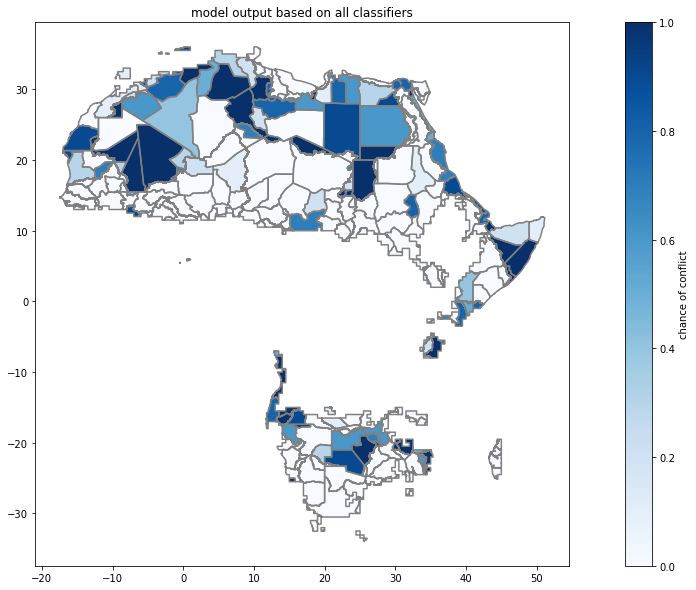

In [16]:
# get the output analysis metrics per chunk that is per classifier
df_hit, gdf_hit = evaluation.polygon_model_accuracy(y_df, global_df, out_dir=None, make_proj=True)

# and plot them separately
ax = gdf_hit.plot(column='chance_of_conflict', legend=True, figsize=(20, 10), cmap='Blues', vmin=0, vmax=1,
         legend_kwds={'label': "chance of conflict", 'orientation': "vertical"})
ax.set_title('model output based on all classifiers')
selected_polygons_gdf.boundary.plot(ax=ax, color='0.5');

In [17]:
# 